In [27]:
!pip install pandas scikit-learn matplotlib

In [28]:
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.dummy import DummyClassifier

In [8]:
def zero_rate(class_frequencies):
    return max(class_frequencies)

def random_rate(class_frequencies):
    return sum([class_frequency ** 2 for class_frequency in class_frequencies])

## Donut Classification

### Zero Rate and Random Rate

In [20]:
y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_real.npy'))

# Get unique values and their counts
_, counts = np.unique(y_true, return_counts=True)

total_elements = len(y_true)

class_frequencies = []

for count in counts:
    class_frequency = (count / total_elements)
    class_frequencies.append(class_frequency)
    
class_frequencies

[0.0018045888115493685,
 0.0005155968032998196,
 0.28899200824954885,
 0.0015467904098994587,
 0.1634441866460428,
 0.05774684196957979,
 0.10930652229956174,
 0.37561227120391855,
 0.0010311936065996391]

In [21]:
print(f'zero rate: {zero_rate(class_frequencies):.4f}')
print(f'random rate: {random_rate(class_frequencies):.4f}')

zero rate: 0.3756
random rate: 0.2666


### Dummy Classifier

In [51]:
def print_scores(y_true, y_pred):
    balanced_accuracy_score = metrics.balanced_accuracy_score(y_true, y_pred)
    weighted_recall_score = metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)
    weighted_precision_score = metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)
    weighted_f1_score = metrics.f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f'balanced accuracy score: {balanced_accuracy_score:.4f}')
    print(f'weighted recall score: {weighted_recall_score:.4f}')
    print(f'weighted precision score: {weighted_precision_score:.4f}')
    print(f'weighted f1 score: {weighted_f1_score:.4f}')

In [52]:
X = np.zeros((len(y_true), 1))

classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(X=None, y=y_true)
y_pred = classifier.predict(y_true)

print_scores(y_true, y_pred)

balanced accuracy score: 0.1111
weighted recall score: 0.3756
weighted precision score: 0.1411
weighted f1 score: 0.2051


In [13]:
donut_10_epochs_y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'10epochs_y_real.npy')).tolist()
donut_20_epochs_y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'20epochs_y_real.npy')).tolist()
donut_30_epochs_y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'30epochs_y_real.npy')).tolist()
    
assert donut_10_epochs_y_true == donut_20_epochs_y_true == donut_30_epochs_y_true

balanced accuracy score: 0.7918
weighted recall score: 0.9969
weighted precision score: 0.9964
weighted f1 score: 0.9965

balanced accuracy score: 0.7685
weighted recall score: 0.9804
weighted precision score: 0.9807
weighted f1 score: 0.9800

balanced accuracy score: 0.7810
weighted recall score: 0.9603
weighted precision score: 0.9638
weighted f1 score: 0.9602


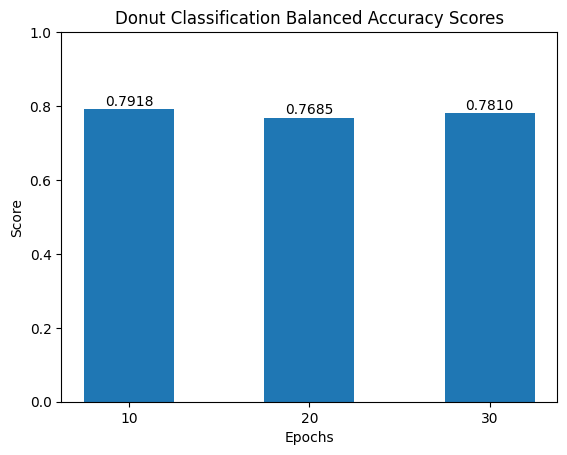

In [53]:
balanced_accuracy_scores = []

x = [10, 20, 30]

for epochs in x:
    y_true = np.load(os.path.join('Arrays', 'DonutClassification', f'{epochs}epochs_y_real.npy'))
    y_pred = np.load(os.path.join('Arrays', 'DonutClassification', f'{epochs}epochs_y_pred.npy'))
    print_scores(y_true, y_pred)
    print()
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    balanced_accuracy_scores.append(balanced_accuracy)
    
plt.bar(x=x, height=balanced_accuracy_scores, width=5)

# Annotate each bar with its value
for i, score in enumerate(balanced_accuracy_scores):
    plt.text(x=x[i], y=score + 0.01, s=f'{score:.4f}', ha='center')

plt.title('Donut Classification Balanced Accuracy Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
# Set x-axis ticks to only the defined values
plt.xticks(x)
plt.ylim(0, 1)
plt.show()

In [8]:
donut_10_epochs_y_true = np.load(os.path.join('Arrays', 'DonutClassification', '10epochs_y_real.npy'))
donut_10_epochs_y_pred = np.load(os.path.join('Arrays', 'DonutClassification', '10epochs_y_pred.npy'))

In [10]:
print(donut_10_epochs_y_true.shape)
print(donut_10_epochs_y_pred.shape)

(3879,)
(3879,)


In [20]:
balanced_accuracy = metrics.balanced_accuracy_score(donut_10_epochs_y_true, donut_10_epochs_y_pred)
round(balanced_accuracy, 4)

0.7918

In [24]:
recall_scores = metrics.recall_score(donut_10_epochs_y_true, donut_10_epochs_y_pred, average=None)
print(recall_scores.round(4))

[0.7143 0.     0.9955 0.6667 1.     1.     1.     1.     0.75  ]


In [ ]:
models = [
    {'name': 'donut_10_epochs', 'path': os.path.join('Arrays', 'DonutClassification')}
]